In [1]:
import wave

obj = wave.open('Save.wav', 'rb')
print(f"Parameters:{obj.getparams()}")

time = obj.getnframes() / obj.getframerate()
print(time)
frames = obj.readframes(-1)
print(type(frames),type(frames[0]))
print(len(frames))

obj_new = wave.open('Save1.wav','wb')
obj_new.setnchannels(1)
obj_new.setsampwidth(4)
obj_new.setframerate(48000)
obj_new.writeframes(frames)
obj_new.close() 




Parameters:_wave_params(nchannels=2, sampwidth=2, framerate=48000, nframes=10398825, comptype='NONE', compname='not compressed')
216.6421875
<class 'bytes'> <class 'int'>
41595300


216.6421875


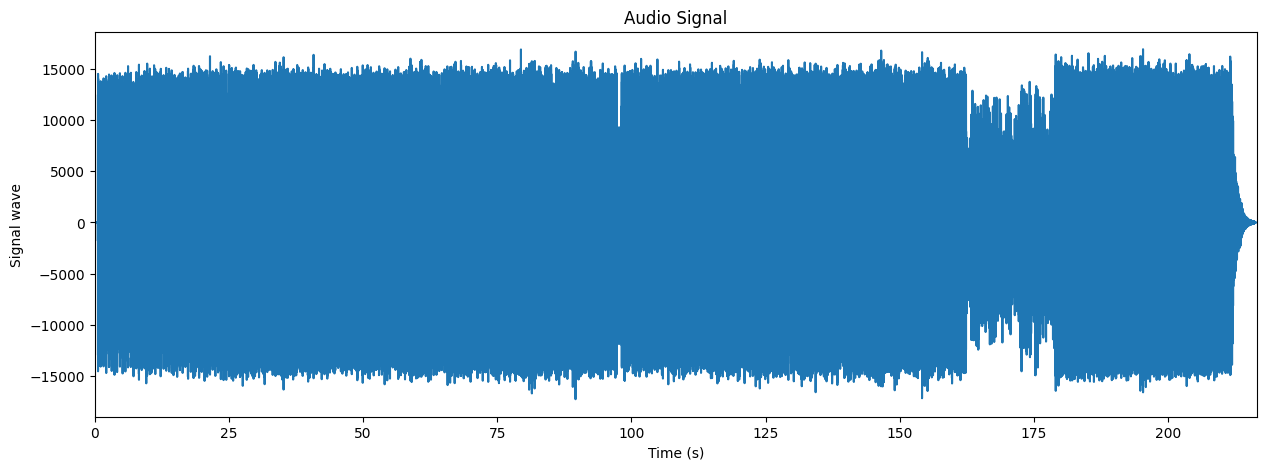

In [5]:
import wave
import matplotlib.pyplot as plt
import numpy as np

with wave.open("Save1.wav",'rb') as obj:
    sample_freq = obj.getframerate()
    n_samples = obj.getnframes()
    signal_wave = obj.readframes(-1)

t_audio = n_samples / sample_freq

signal_array = np.frombuffer(signal_wave, dtype=np.int16)
times = np.linspace(0,t_audio,num=len(signal_array))
plt.figure(figsize=(15,5))
plt.plot(times, signal_array)
plt.title("Audio Signal")
plt.ylabel("Signal wave")
plt.xlabel("Time (s)")
plt.xlim(0,t_audio)
plt.show()


In [13]:
import pyaudio
import wave
import wave
import matplotlib.pyplot as plt
import numpy as np

def record(duration):
    FRAMES_PER_BUFFER = 3200
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 16000

    p = pyaudio.PyAudio()
    stream = p.open(
        format=FORMAT,
        channels=CHANNELS,
        rate=RATE,
        input=True,
        frames_per_buffer=FRAMES_PER_BUFFER
    )

    print('Start recording')
    seconds = duration
    frames = []
    for i in range(0, int(RATE/FRAMES_PER_BUFFER*seconds)):
        data = stream.read(FRAMES_PER_BUFFER)
        frames.append(data)

    print('End recording')
    stream.stop_stream()
    stream.close()
    p.terminate()

    with wave.open("output.wav",'wb') as obj:
        obj.setnchannels(CHANNELS)
        obj.setsampwidth(p.get_sample_size(FORMAT))
        obj.setframerate(RATE)
        obj.writeframes(b"".join(frames))
    return 'output.wav'

def plotgraph(filename):
    with wave.open(filename,'rb') as obj:
        sample_freq = obj.getframerate()
        n_samples = obj.getnframes()
        signal_wave = obj.readframes(-1)

    t_audio = n_samples / sample_freq

    signal_array = np.frombuffer(signal_wave, dtype=np.int16)
    times = np.linspace(0,t_audio,num=len(signal_array))
    plt.figure(figsize=(15,5))
    plt.plot(times, signal_array)
    plt.title("Audio Signal")
    plt.ylabel("Signal wave")
    plt.xlabel("Time (s)")
    plt.xlim(0,t_audio)
    plt.show()


In [12]:
import numpy

In [11]:
from pydub import AudioSegment
audio = AudioSegment.from_wav("Save.wav")
audio = audio + 6
audio = audio * 2
audio = audio.fade_in(2000)
audio.export("mashup.mp3",format="mp3")
audio2 = AudioSegment.from_mp3("mashup.mp3")
print("done")

done


In [4]:
import requests
from api_secrets import API_KEY_ASSEMBLYAI
import time

def Transcribe_Audio(filepath) -> str :
    headers = {'authorization': API_KEY_ASSEMBLYAI}
    upload_endpoint = "https://api.assemblyai.com/v2/upload"


    def upload(filename, headers):
        def read_file(filename, chunk_size = 5242800):
            with open(filename,'rb') as _file:
                while True:
                    data = _file.read(chunk_size)
                    if not data:
                        break
                    yield data

        upload_response = requests.post(upload_endpoint,headers=headers,data=read_file(filename))
        audio_url = upload_response.json()['upload_url']
        return audio_url

    #transcribe
    def transcribe(audio_url, headers):
        transcript_endpoint = "https://api.assemblyai.com/v2/transcript"
        json = {"audio_url": audio_url}
        transcript_response = requests.post(transcript_endpoint,json=json, headers=headers)
        transcript_id = transcript_response.json()['id']
        return transcript_id

    #poll
    def poll(transcript_id):
        transcript_endpoint = "https://api.assemblyai.com/v2/transcript"
        polling_endpoint =  transcript_endpoint + '/' + transcript_id
        polling_response = requests.get(polling_endpoint, headers=headers)
        return polling_response.json()

    def get_results_url(transcript_id):

        while True:
            data = poll(transcript_id)

            if data['status'] == 'completed':
                return data, None
            elif data['status'] == 'error':
                return data, data['error']
            time.sleep(10)

    #save transcript
    def save(filename, data=None, error=None):
        if data:
            output_filename = filename + ".txt"
            with open(output_filename,'w') as f:
                f.write(data['text'])
            print("Transcription saved")
        else:
            print("Error", error)

    transcript_id = transcribe(upload(filepath,headers),headers)
    data, error = get_results_url(transcript_id)
    if data:
        return data['text']
    elif error:
        return error
    # save(filepath, data, error)




Start recording
End recording
Transcribing...
According to all known laws of aviation, there's no way a bee should be able to fly. Its wings are far too small to get its fat little body off the ground.


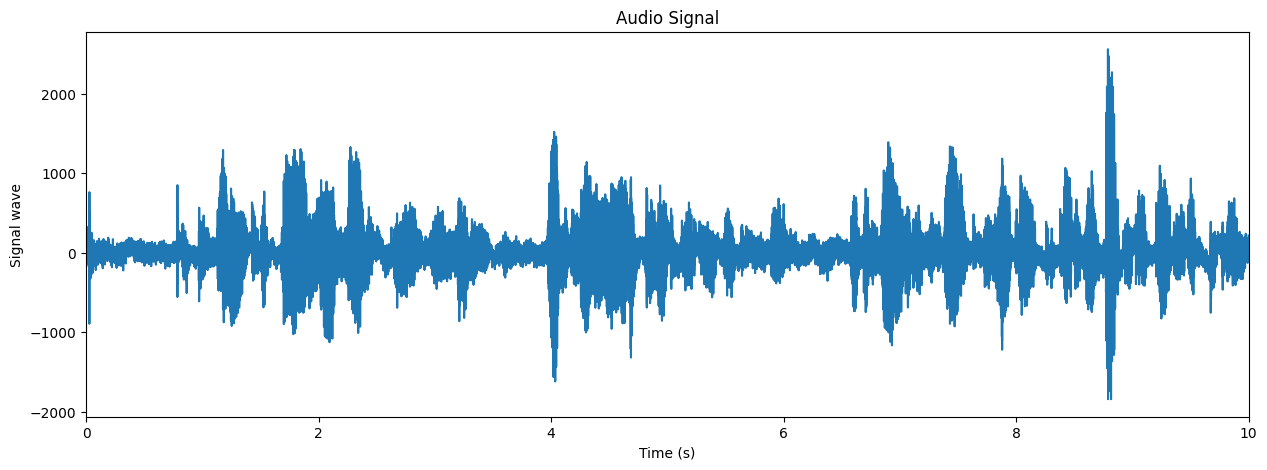

In [14]:
filename = record(10)
print("Transcribing...")
print(Transcribe_Audio(filename))
plotgraph(filename)